In [1]:
library('mxnet')
library(plyr)
library('uuid')
library('fields')
library('IRdisplay')
#install.packages('geosphere',repos='https://cran.rstudio.com')
library('geosphere')
library(jsonlite)
library(ggplot2)
#The model is a neural network trained on five million hands. Requires the hand to be formatted into a 16 by 16 image
model <- mx.model.load('CUDA_model2/pokerhands5M_3.model',600)

Loading required package: spam
Loading required package: grid
Spam version 1.4-0 (2016-08-29) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps

Attaching package: ‘maps’

The following object is masked from ‘package:plyr’:

    ozone


Attaching package: ‘IRdisplay’

The following object is masked from ‘package:spam’:

    display

Loading required package: sp


Vegas casinos (latitude, longitude)

* MGM Grand Show Bar: 36.101551, -115.171579
* MGM Grand Garden Area: 36.104740, -115.168599
* New York/New York Center Bar: 36.104740, -115.168599
* Exalibur Poker Room: 36.098796, -115.175448
* Wynn Red 8: 36.125926, -115.166224
* Treasure Island: 36.124703, -115.172305
* El Cortez: 36.168953, -115.138972
* Golden Nugget: 36.170495, -115.145404
* Plaza: 36.171535, -115.147113
* Main Street Station: 36.174308, -115.145318
* California: 36.172837, -115.145038
* Westgate: 36.135330, -115.151643
* Mirage Players Club: 36.120970, -115.174947
* Mirage Calypso: 36.121561, -115.176478
* Caesars : 39.356116, -74.435764


Use 'geosphere' package, distm() to get distance matrix (Can be a vector of two numbers, a matrix of 2
columns (first one is longitude, second is latitude))

In [2]:
#Set the locations and calculate the distance matrix for the possible GPS locations of the hands.
locations <- rbind(c(-115.171579,36.101551), c(-115.168599,36.104740), c(-115.168599,36.104740), c(-115.175448,36.098796),
                   c(-115.166224,36.125926), c(-115.172305, 36.124703), c(-115.138972, 36.168953),
                   c(-115.145404, 36.170495), c(-115.147113, 36.171535), c(-115.145318, 36.174308),
                   c(-115.145038, 36.172837), c(-115.151643, 36.135330), c(-115.174947, 36.120970),
                   c(-115.176478, 36.121561), c(-74.435764,39.356116 ))
location_names <- c('MGM Grand Show Bar','MGM Grand Garden Area', 'New York/New York', 'Excalibur', 'Wynn', 'Treasure Island','El Cortez', 
                    'Golden Nugget', 'Plaza', 'Main Street Station', 'California', 'Westgate',
                    'Mirage Players Club','Mirage Calypso', 'Caesars')
location_sub <- c('R1T1H1','R1T1H2','R1T2H1','R1T2H2','R2T1H1','R2T1H2','R2T2H1','R2T2H2','R3T1H1','R3T1H2','R3T2H1','R3T2H2')
#print(locations[8,])
#print(location_names[[8]])
distances<-distm(locations)/1000
#distances
all_locations<-merge(data.frame(location_names,stringsAsFactors=FALSE),data.frame(location_sub,stringsAsFactors=FALSE))
names(all_locations)<-c("Loc.Name","Loc.Sub")
#all_locations <- ddply(locations[grep(hand.loc.name, location_names),2]
                           
all_locations<-ddply(all_locations,c("Loc.Name"),
      transform,
      Loc.lat = locations[grep(Loc.Name[[1]], location_names),2],
      Loc.lon = locations[grep(Loc.Name[[1]], location_names),1])
                           
#hand.loc.lon <- locations[grep(hand.loc.name, location_names),1]

Hands are scored on the following scale:

* 9 : "Royal Flush"
* 8 : "Straight Flush"
* 7 : "Four of a Kind"
* 6 : "Full House"
* 5 : "Flush"
* 4 : "Straight"
* 3 : "Three of a Kind"
* 2 : "Two Pair"
* 1 : "Pair"
* 0 : "High Card"


In [3]:
#Suit ints: sdch
#Rank ints: 23456789TJQKA

#Generate deck for creating hands
deck <- paste0(rep(c(2:9, "T", "J", "Q", "K", "A"), 4),  #card values
               rep(c("s", "h", "d", "c"), each = 13)) #suits

#set up repeatedly used values for scoring the hands
cardarray <- rep(0,52)
cardID <- 2:14
names(cardID) <- c("2", "3", "4","5","6","7","8","9","T","J","Q","K","A")
suiteID <- 1:4
names(suiteID) <- c("s","d","c","h")
handarray <- rep(0,256)

handValue <- function(hand){
    #cardarray[int(suit_int)*13 + rank_int] = 1
    for (i in 1:length(hand)){
        card <- hand[i]
        cardarray[ cardID[[substr(card,0,1)]]-1 + suiteID[[substr(card,nchar(card),nchar(card))]]*13-13] <- 1     
    }
    
    handConverted<-data.matrix(cardarray)
    #Paste the data in the right places to make this work as a 16 by 16 array and then reshape for scoring
    handarray[99:111] <- handConverted[1:13]
    handarray[115:127]<- handConverted[14:26]
    handarray[131:143]<- handConverted[27:39]
    handarray[147:159]<- handConverted[40:52]

    h2<-data.matrix(handarray)
    h_array <- h2
    dim(h_array)<-c(16,16,1,1)
    
    predicted <- predict(model, h_array)
    predicted_label <- max.col(t(predicted)) - 1
    return(predicted_label)
}

handVis <- function(hand){
    #cardarray[int(suit_int)*13 + rank_int] = 1
    for (i in 1:length(hand)){
        card <- hand[i]
        cardarray[ cardID[[substr(card,0,1)]]-1 + suiteID[[substr(card,nchar(card),nchar(card))]]*13-13] <- 1     
    }
    
    handConverted<-data.matrix(cardarray)
    #Paste the data in the right places to make this work as a 16 by 16 array and then reshape for scoring
    handarray[99:111] <- handConverted[1:13]
    handarray[115:127]<- handConverted[14:26]
    handarray[131:143]<- handConverted[27:39]
    handarray[147:159]<- handConverted[40:52]

    h2<-data.matrix(handarray)
    h_array <- h2
    dim(h_array)<-c(16,16)

    return(h_array)
}

In [4]:
printHand<- function(hand){
    newstr <- ''
    for (card in hand){
        newstr <- paste(newstr,substr(card,1,1))
        if (substr(card,2,2) == 'd' ){
            newstr <- paste0(newstr,'♦')
        }else if (substr(card,2,2) == 'h' ){
            newstr <- paste0(newstr,'♥')
        }else if (substr(card,2,2) == 's' ){
            newstr <- paste0(newstr,'♠')
        }else{
            newstr <- paste0(newstr,'♣')
        }
        
        
    }
    return(trimws(newstr))
}


In [16]:
nhands <- 10

#The Card information comes from a JSON array with the following information:
#* FaceValue: 2 character string
#* CardID: a UUID for each card
#* HandID: (starting HandID for each card)
#* Hand.Loc.Lat (start location latitude)
#* Hand.Loc.Lon: (start location longitude)
#* Hand.Loc.Name: (start Casino name)
#* Hand.Loc.Sub: (start table, hand, seat ID for each room)
#* TransportMult:  (multiplier on moving this card (mostly 1))
#* OccupiedLevel: (0 = available, 1000 = can't move (i.e. table card in Hold'em)

hand_locations <- all_locations[sample(nrow(all_locations), nhands), ]

cardDF <- data.frame(FaceValue = character(), 
                        CardID=character(),
                        HandID=character(),
                        Hand.Loc.Name=character(),
                        Hand.Loc.Sub=character(),
                        Hand.Loc.Lat=numeric(),
                        Hand.Loc.Lon=numeric(),
                        Card.Trans.Mult=numeric(),
                        Card.Occ.Level = numeric(),stringsAsFactors=FALSE)

for (handnum in 1:nhands){
    shuffledhand <-sample(deck,size=sample(5:7,1)) #Shuffle decks
    
    hand.loc.name<-hand_locations[handnum,1]
    hand.loc.sub <-hand_locations[handnum,2]
    #print(hand.loc.name)
    #Will need hand.loc index to get distance matrix: grep(hand.loc.name, location_names)
    hand.loc.lat <- locations[grep(hand.loc.name, location_names),2]
    hand.loc.lon <- locations[grep(hand.loc.name, location_names),1]
    handID = UUIDgenerate() #unique handID number
    for (i in 1:length(shuffledhand)){
        #simulate bringing in JSON data on each card (from the Dealer server for now)
        
        cardString<-toJSON(data.frame(FaceValue=shuffledhand[[i]],
                        CardID=UUIDgenerate(),
                        HandID=handID,
                        Hand.Loc.Name=hand.loc.name,
                        Hand.Loc.Sub=hand.loc.sub,
                        Hand.Loc.Lat=hand.loc.lat,
                        Hand.Loc.Lon=hand.loc.lon,
                        Card.Trans.Mult=runif(1)*(1+rpois(1, 0.5)),
                        Card.Occ.Level = 1000 * rpois(1,0.1)))
        #Join all the cards to the main data frame
        cardDF <- rbind(cardDF, fromJSON(cardString))
    }
}


# Build a HandDF to keep track of the following information:
#* HandID: (starting HandID for each card)
#* Hand.Loc.Lat (start location latitude)
#* Hand.Loc.Lon: (start location longitude)
#* Hand.Loc.Name: (start Casino name)
#* Hand.Loc.Sub: (start table, hand, seat ID for each room)

#handDF <- data.frame(HandID=character(),
#                        Hand.Loc.Name=character(),
#                        Hand.Loc.Sub=character(),
#                        Hand.Loc.Lat=numeric(),
#                        Hand.Loc.Lon=numeric(),stringsAsFactors=FALSE)
handDF <- unique(cardDF[c('HandID','Hand.Loc.Name','Hand.Loc.Sub','Hand.Loc.Lat','Hand.Loc.Lon')])


#Add three more columns to the card dataframe (and remove the redundant hand information):
#* CardScore: the hand score divided by the number of cards in the hand
#* Distance: the distance the card has to travel from its initial hand to the current hand
#* CurHandID: current HandID including trades

cardDF<-ddply(cardDF,c("HandID"),
      transform,
      CardScore = handValue(FaceValue)/length(FaceValue))
cardDF['CurHandID'] <- cardDF['HandID']
cardDF['Distance'] <- 0.0
cardDF[c('Hand.Loc.Name','Hand.Loc.Sub','Hand.Loc.Lat','Hand.Loc.Lon')] <- NULL
print(sum(cardDF$CardScore))
#Check Hand Scoring:
#ddply(cardDF[c('FaceValue','HandID','CardScore')],c("HandID"),
#      transform,
#      HandScore = sum(CardScore))


[1] 11


In [17]:
handDF

,HandID,Hand.Loc.Name,Hand.Loc.Sub,Hand.Loc.Lat,Hand.Loc.Lon
1,cd5f20df-40cc-4cc7-82bb-45e0a84c2564,Plaza,R3T1H1,36.1715,-115.1471
8,81bf9867-864f-42af-b128-e4ad2794a9b6,Exalibur,R1T2H2,36.0988,-115.1754
13,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754
20,7a2cb189-7eff-4657-af15-4e53bd744506,Treasure Island,R2T1H1,36.1247,-115.1723
26,d2e36a04-0456-4595-971f-5d4f91dc1a18,Mirage Calypso,R3T1H2,36.1216,-115.1765
33,e631d98c-076a-4252-ab21-60c78c970cf6,California,R2T1H1,36.1728,-115.1450
40,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,California,R3T1H2,36.1728,-115.1450
46,bfa5276f-770b-4193-b0b9-cd9430877d5a,Caesars,R2T2H2,39.3561,-74.4358
51,7f1d1989-21da-435e-9837-35c860fdaa76,California,R2T2H2,36.1728,-115.1450
58,f4d6c478-96f0-4517-a83d-954da5c3b027,El Cortez,R2T1H1,36.1690,-115.1390


Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Las+Vegas&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Las%20Vegas&sensor=false
Warning message:
“Removed 1 rows containing missing values (geom_point).”

Warning message:
“Removed 1 rows containing missing values (geom_point).”

pdf 
  2

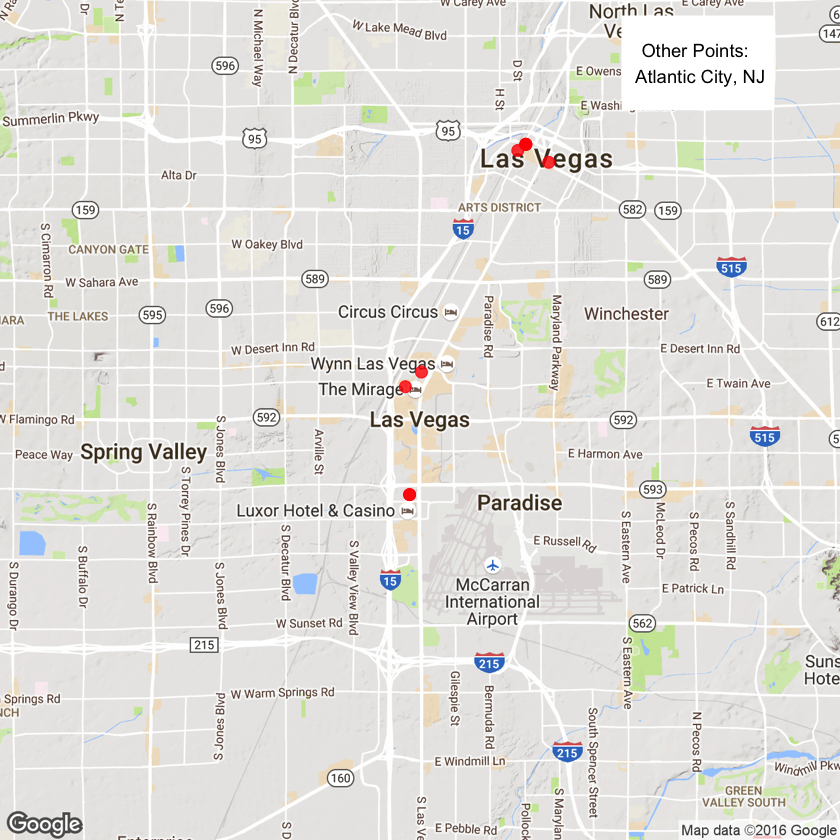

In [18]:
library(ggmap)

map <- qmap('Las Vegas', zoom = 12)
map<-map + geom_point(data = handDF, aes(x = Hand.Loc.Lon, y = Hand.Loc.Lat), color="red", size=3, alpha=0.8)
map <- map + annotate("rect", xmin = -115.08, xmax = -115.12, ymin = 36.18, ymax = 36.2, alpha = 1, fill="white")
map<-map + annotate("text", x =-115.1, y = 36.19 , label = "Other Points: \n Atlantic City, NJ",colour = "black")
map
pdf(file="hand_locations.pdf", width=7, height=6)
map
dev.off()

In [19]:


plotHands <- function(cardDFt,filename,final=FALSE){
    if (final){
        handlist <- unique(cardDFt$CurHandID)
    }
    else{
        handlist <- unique(cardDFt$HandID)
    }
    
    #pdf(file="inputhands.pdf", width=2, height=2)
    cairo_pdf(filename, family="Arial Unicode MS", width=5, height=2)
    layout(matrix(1:10,nrow=2))
    for (hand in handlist) {
        if (final){
            newhand <- cardDFt[cardDFt$CurHandID == hand, 'FaceValue']
        }
        else{
            newhand <- cardDFt[cardDFt$HandID == hand, 'FaceValue']
        }
        
        
        outputData <- handVis( newhand)
        handscore<-handValue(newhand)
        handstring<-paste(newhand)
        print(printHand(newhand))
        par(mar=c(0.1,0.1,0.1,0.1))
        pdf.options(encoding='ISOLatin2.enc')
        image(outputData,
              xaxt='n', yaxt='n',
              col = grey(seq(0, 1, length = 256)))
        text(0.5,0.8,printHand(newhand),col="yellow",cex=0.8)
    }
    dev.off()
}
plotHands(cardDF,"inputhands.pdf")

[1] "T♣ 9♠ 5♥ 9♦ 8♦ 5♠ 3♦"
[1] "6♠ 8♣ 9♣ T♠ 7♦ 3♦"
[1] "9♥ 4♠ 7♠ 2♣ T♦ A♣"
[1] "6♠ 2♥ 4♥ T♣ 5♠ 4♠ 9♥"
[1] "8♦ 7♦ 8♥ J♦ 3♦"
[1] "4♣ 4♥ J♠ A♦ 5♣"
[1] "Q♠ 2♥ 2♣ 7♦ K♣ 6♠ Q♥"
[1] "6♣ 2♥ 8♥ 5♥ 4♠ T♣ Q♠"
[1] "8♥ 7♦ A♣ 3♣ Q♣ 2♣ 5♦"
[1] "8♦ Q♥ 2♠ 7♥ A♠"


pdf 
  2

In [31]:
cards<-ddply(cardDF,c("HandID"),
      transform,
      CardScore = handValue(FaceValue))
head(cards,80)

FaceValue,CardID,HandID,Card.Trans.Mult,Card.Occ.Level,CardScore,CurHandID,Distance
Tc,c9345e7f-8f6c-4d86-951c-99201cf76685,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.5033,0,2,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0
9s,7d12bee0-2124-420b-a123-79a360bafb00,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.5746,1000,2,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0
5h,b399d6b0-6855-4e0b-ac45-6a19cd5b4744,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,2.9759,0,2,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0
9d,2d6fd22e-e367-4f69-a848-a27d10196ba4,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,1.9594,0,2,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0
8d,1c61632d-0b7b-4f5c-a586-e0eff88a61c1,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.2570,0,2,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0
5s,66d8383c-13a7-4930-b93d-0293ff43b9b6,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.8916,0,2,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0
3d,3475587c-61f3-43a0-a2d0-eec0c2a94be5,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,3.5171,0,2,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0
6s,9f77e5a0-9050-46d7-b04a-85218a52f975,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,0.1962,0,4,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,0
8c,b8072468-32a8-41eb-a119-f3109b9c6b94,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,2.8896,0,4,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,0
9c,41883928-97ad-4320-beb9-91e54e98291c,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,1.4229,0,4,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,0


In [20]:
#Algorithm from https://github.com/toddwschneider/shiny-salesman/blob/master/helpers.R

#Temperature anneal based on an s-curve
current_temperature <- function(iter, s_curve_amplitude, s_curve_center, s_curve_width) {
  s_curve_amplitude * s_curve(iter, s_curve_center, s_curve_width)
}

s_curve <- function(x, center, width) {
  1 / (1 + exp((x - center) / width))
}

#Function to carry out a card swap and check that it is legal (no duplicated cards in a hand)
cardSwap <- function(candidate_config, hand_info){

    legalswap <- FALSE
    firstcard <- NULL
    secondcard <- NULL
    
    while (!legalswap){
        swaphands <- sample(unique(candidate_config['CurHandID'])[,],2)
        swapcards <- c(candidate_config[candidate_config['CurHandID']==swaphands[[1]],][sample(nrow(candidate_config[candidate_config['CurHandID']==swaphands[[1]],]), 1),'CardID'],
                      candidate_config[candidate_config['CurHandID']==swaphands[[2]],][sample(nrow(candidate_config[candidate_config['CurHandID']==swaphands[[2]],]), 1),'CardID'])
        #print(swaphands)
        #print(swapcards)

        #run the swap using a temp card
        firstcard <- candidate_config[candidate_config$CardID == swapcards[[1]],]
        secondcard <- candidate_config[candidate_config$CardID == swapcards[[2]],]
        candidateDF <- candidate_config
        candidateDF[candidateDF$CardID == swapcards[[1]],'CurHandID'] <- secondcard$CurHandID
        candidateDF[candidateDF$CardID == swapcards[[2]],'CurHandID'] <- firstcard$CurHandID
        #print(firstcard)
        #print(secondcard)
        legalswap <- !any(duplicated(candidateDF[candidateDF$CurHandID == firstcard$CurHandID,'FaceValue'])) ||
                        !any(duplicated(candidateDF[candidateDF$CurHandID == secondcard$CurHandID,'FaceValue']))

        #print(legalswap)
    }
    
    #re-score the two new configurations
    #TODO: Start here in fixing the rest of this.
    
    #Score the new configurations
    hand1<-candidateDF[candidateDF$CurHandID==swaphands[[1]],'FaceValue']
    candidateDF[candidateDF$CurHandID==swaphands[[1]],'CardScore'] <- handValue(hand1)/length(hand1)
    hand2<-candidateDF[candidateDF$CurHandID==swaphands[[2]],'FaceValue']
    candidateDF[candidateDF$CurHandID==swaphands[[2]],'CardScore'] <- handValue(hand2)/length(hand2)

    #Move the cards to their new locations and update the displacement vector
    tempcard <- firstcard
    firstcard['CurHandID'] <- secondcard['CurHandID']
    secondcard['CurHandID'] <- tempcard['CurHandID']

    p1<-hand_info[hand_info$HandID == firstcard$CurHandID ,c('Hand.Loc.Lon','Hand.Loc.Lat')]
    p2<-hand_info[hand_info$HandID == firstcard$HandID ,c('Hand.Loc.Lon','Hand.Loc.Lat')]
    candidateDF[candidateDF$CardID==firstcard$CardID,'Distance'] <- distGeo(p1,p2)/1000 #Returns distance in meters, we want kilometers

    p1<-hand_info[hand_info$HandID == secondcard$CurHandID ,c('Hand.Loc.Lon','Hand.Loc.Lat')]
    p2<-hand_info[hand_info$HandID == secondcard$HandID ,c('Hand.Loc.Lon','Hand.Loc.Lat')]
    candidateDF[candidateDF$CardID==secondcard$CardID,'Distance'] <- distGeo(p1,p2)/1000 #Returns distance in meters, we want kilometers

    
    return(list(candidate_config=candidateDF,hands=swaphands,cards=swapcards))    
    
}

In [21]:
run_intermediate_anneal <- function(hand_config, 
                                    hand_score, 
                                    best_config, 
                                    best_score,
                                    starting_iteration, 
                                    number_of_iterations, 
                                    s_curve_amplitude, 
                                    s_curve_center, 
                                    s_curve_width,
                                    hand_info) {
    
    score_history <- rep(0,number_of_iterations)

    for(i in 1:number_of_iterations) {
       
        
        iter <- starting_iteration + i 
        temp <- current_temperature(iter, s_curve_amplitude, s_curve_center, s_curve_width)
        
        #try a swap: if it is a good swap, we'll keep it later
        swap <- cardSwap(hand_config,hand_info)
        candidate_config <- swap$candidate_config
        
        
        #score the overall configuration based on this update
        candidate_score <- sum(candidate_config$CardScore)
        
        #the change in score is now dependent on the distance traveled - more distance means less benefit for trading
        
        #TODO: add in the scale multiplier for each card: multiply the distance matrix by both of them
        #TODO: add in the occupied levels: - occupiedLevel1 - occupiedLevel2 (if either of these is non-zero, will prohibit swap)
        subtractors <- candidate_config[candidate_config$CardID == swap$cards[[1]],'Card.Occ.Level'] + 
                        candidate_config[candidate_config$CardID == swap$cards[[1]],'Card.Trans.Mult'] * 
                        candidate_config[candidate_config$CardID == swap$cards[[1]],'Distance'] +
                        candidate_config[candidate_config$CardID == swap$cards[[2]],'Card.Occ.Level'] + 
                        candidate_config[candidate_config$CardID == swap$cards[[2]],'Card.Trans.Mult'] * 
                        candidate_config[candidate_config$CardID == swap$cards[[2]],'Distance'] 
        #print(subtractors)
        
        delta <- candidate_score - hand_score - subtractors
              
        
        if (temp > 0 ) {
            #This tends to 1 
            ratio <- exp( delta / temp)
        } else {
            #At zero temp, we only keep good flips
            ratio <- as.numeric(delta > 0)
        }
        
        #Get a random number: if it is less than our ratio, keep the flip
        if (runif(1) < ratio) {
          hand_config <- candidate_config
          hand_score <- candidate_score

          if (hand_score > best_score) {
            best_config <- hand_config
            best_score <- hand_score
            #print("score upgrade")
          }
        }
        score_history[i] <- hand_score
    }

    return(list(hand_config=hand_config, hand_score=hand_score, best_config=best_config, best_score=best_score, score_history=score_history)) 
}

pdf 
  2

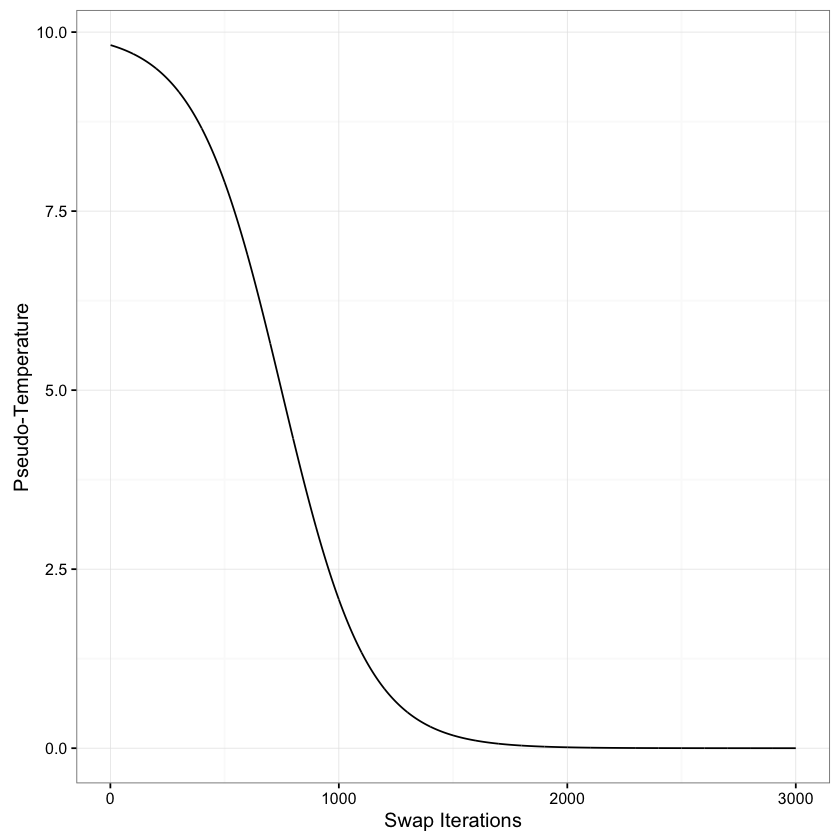

In [22]:
#Look at how the temperature evolves in time for this system.
print_iterations <- length(unique(cardDF$HandID))
steps_per_iteration <- 300
t_max <- 10
number_of_iterations <- print_iterations * steps_per_iteration
starting_iteration <- 1
t_center <-number_of_iterations/4
t_width <-number_of_iterations/16

tdata <-rep(0,number_of_iterations)
for(i in 1:number_of_iterations) { 
    iter <- starting_iteration + i 
    temp <- current_temperature(iter, t_max, t_center, t_width)
    tdata[i] <- temp    
}
temps <- data.frame(1:number_of_iterations, tdata)
names(temps) <- c("Iterations","PseudoTemperature")
#print(head(temps))
p1 <- ggplot(temps,aes(x=Iterations,y=PseudoTemperature)) + theme_bw() + geom_line() + labs(y="Pseudo-Temperature",x="Swap Iterations")
p1
pdf(file="temp_ramp.pdf", width=5, height=3)
p1
dev.off()

In [23]:
score_history <- rep(0,print_iterations*steps_per_iteration)

hand_config<-cardDF
#hand_config$Card.Trans.Mult <- 10*hand_config$Card.Trans.Mult
#hand_config$Card.Occ.Level <- 0.0

hand_score<-sum(cardDF$CardScore)
best_config<-hand_config
best_score<-hand_score
anneal_results <- NULL
roundTimes <-rep(0,number_of_iterations)
for (i in 1:print_iterations){
    start.time <- Sys.time()

    iter <- steps_per_iteration*(i-1)
    anneal_results<-run_intermediate_anneal(hand_config, hand_score, best_config, best_score,
                                            iter, 
                                            steps_per_iteration, 
                                            t_max, 
                                            t_center, 
                                            t_width,
                                            handDF)
    hand_config <- anneal_results$hand_config
    hand_score <- anneal_results$hand_score
    best_config <- anneal_results$best_config
    best_score <- anneal_results$best_score
    score_history[(iter+1):(iter+steps_per_iteration)]<-anneal_results$score_history
    end.time <- Sys.time()
    time.taken <- end.time - start.time
    roundTimes[i] <- time.taken
    display(paste("Round",i,"of",print_iterations,"with score",best_score,"in time:",format(time.taken,digits=2)))
}

[1] "Round 1 of 10 with score 19 in time: 3.8 secs"

[1] "Round 2 of 10 with score 19 in time: 4.1 secs"

[1] "Round 3 of 10 with score 23 in time: 4.2 secs"

[1] "Round 4 of 10 with score 27 in time: 4 secs"

[1] "Round 5 of 10 with score 34 in time: 4.3 secs"

[1] "Round 6 of 10 with score 35 in time: 4 secs"

[1] "Round 7 of 10 with score 36 in time: 4.1 secs"

[1] "Round 8 of 10 with score 36 in time: 4.6 secs"

[1] "Round 9 of 10 with score 40 in time: 3.8 secs"

[1] "Round 10 of 10 with score 41 in time: 4.3 secs"

pdf 
  2

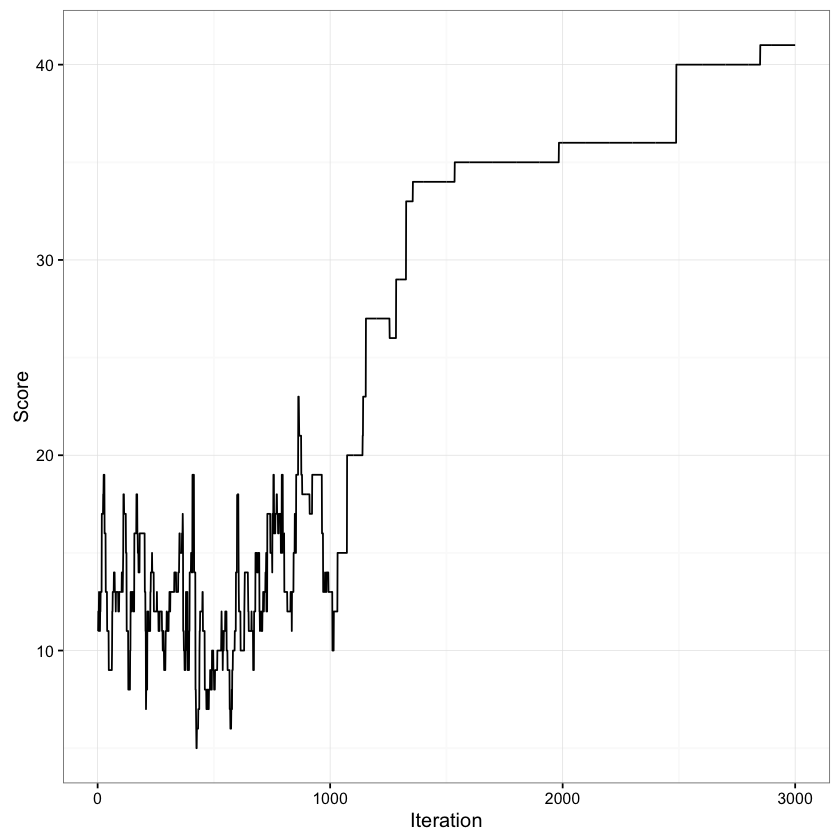

In [24]:
scores <- data.frame(1:(print_iterations*steps_per_iteration), score_history)
names(scores) <- c("Iteration","Score")
p2<-ggplot(scores, aes(x=Iteration, y=Score)) + geom_line() + theme_bw()
p2
pdf(file="score_history.pdf", width=5, height=3)
p2
dev.off()

In [25]:
plotHands(anneal_results$best_config,"outputhands.pdf",TRUE)

[1] "T♣ 5♥ 5♠ 2♣ 2♥"
[1] "9♠ 9♦ 8♦ 3♦ T♦ J♦ 6♠"
[1] "6♠ 8♣ 7♦ 9♥ 4♥ T♣ T♣"
[1] "9♣ 4♠ 2♣ K♣ 6♣ A♣"
[1] "T♠ A♣ 9♥ Q♠ 7♦ Q♥ A♠"
[1] "3♦ 5♠ Q♠ 3♣ Q♣ 5♦ Q♥"
[1] "4♠ 7♠ 8♦ 7♦ 8♥ 7♥"
[1] "6♠ 3♦ 2♥ 8♥ 5♥ 4♠ 7♦"
[1] "8♥ 2♥ 2♣ 8♦ 2♠"
[1] "4♣ 4♥ J♠ A♦ 5♣"


pdf 
  2

In [34]:
cards<-ddply(anneal_results$best_config,c("CurHandID"),
      transform,
      CardScore = handValue(FaceValue))
head(cards,80)

FaceValue,CardID,HandID,Card.Trans.Mult,Card.Occ.Level,CardScore,CurHandID,Distance
9s,7d12bee0-2124-420b-a123-79a360bafb00,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.5746,1000,5,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.0000000
9d,2d6fd22e-e367-4f69-a848-a27d10196ba4,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,1.9594,0,5,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.0000000
8d,1c61632d-0b7b-4f5c-a586-e0eff88a61c1,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.2570,0,5,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.0000000
3d,3475587c-61f3-43a0-a2d0-eec0c2a94be5,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,3.5171,0,5,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.0000000
Td,7d8c5e04-0f3b-49b8-99cd-c6765296eaa0,7a2cb189-7eff-4657-af15-4e53bd744506,0.8053,0,5,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,2.8874137
Jd,4326a154-fa8c-48cf-bb75-834c17ba5b18,81bf9867-864f-42af-b128-e4ad2794a9b6,0.1880,0,5,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,0.0000000
6s,6dcee572-3e04-44eb-8102-4f429518075b,cd5f20df-40cc-4cc7-82bb-45e0a84c2564,0.0291,0,5,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,8.4595208
9c,41883928-97ad-4320-beb9-91e54e98291c,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,1.4229,0,5,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,0.0000000
4s,c0825244-3caf-4b12-8df3-01b4b4295ffe,7f1d1989-21da-435e-9837-35c860fdaa76,1.6352,0,5,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,0.0000000
2c,a243425f-badc-49f2-87a9-d39cbd3a5396,cd5f20df-40cc-4cc7-82bb-45e0a84c2564,0.7068,0,5,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,0.2377044


In [26]:
print(paste('New Score:',anneal_results$best_score))
best_config <-anneal_results$best_config
print(paste('Number of cards trading:', nrow(best_config[best_config$HandID !=best_config$CurHandID  ,]),'of',nrow(best_config)))
#best_config[best_config$HandID !=best_config$CurHandID  ,]

[1] "New Score: 41"
[1] "Number of cards trading: 40 of 62"


In [27]:
#Next step: determine the swap matrix: who needs to go where?
#Use the handDF, HandID, and CurHandID to determine this - should be some kind of join.
#End result: want a dataframe with the following information:
#* CardID
#* HandID
#* Hand.Loc.Name
#* Hand.Loc.Sub
#* Hand.Loc.Lat
#* Hand.Loc.Lon
#* New.HandID
#* New.Hand.Loc.Name
#* New.Hand.Loc.Sub
#* New.Hand.Loc.Lat
#* New.Hand.Loc.Lon

#From this, we should be able to put together shipping information for each card.

exchangeDF <- best_config[c('CardID','HandID','CurHandID')]
exchangeDF <- merge(exchangeDF, handDF, by='HandID' )
exchangeDF <- merge(exchangeDF, handDF, by.x='CurHandID',by.y='HandID' )
names(exchangeDF) <- c('New.HandID','HandID','CardID','Hand.Loc.Name','Hand.Loc.Sub','Hand.Loc.Lat','Hand.Loc.Lon',
                      'New.Hand.Loc.Name','New.Hand.Loc.Sub','New.Hand.Loc.Lat','New.Hand.Loc.Lon')
exchangeDF <- exchangeDF[,c(3,2,4,5,6,7,1,8,9,10,11)]
exchangeDF <- exchangeDF[order(exchangeDF$HandID),]
output<-toJSON(exchangeDF)
head(exchangeDF,10 )

,CardID,HandID,Hand.Loc.Name,Hand.Loc.Sub,Hand.Loc.Lat,Hand.Loc.Lon,New.HandID,New.Hand.Loc.Name,New.Hand.Loc.Sub,New.Hand.Loc.Lat,New.Hand.Loc.Lon
1,1c61632d-0b7b-4f5c-a586-e0eff88a61c1,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754
2,7d12bee0-2124-420b-a123-79a360bafb00,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754
3,3475587c-61f3-43a0-a2d0-eec0c2a94be5,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754
4,2d6fd22e-e367-4f69-a848-a27d10196ba4,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754
27,c9345e7f-8f6c-4d86-951c-99201cf76685,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754,81bf9867-864f-42af-b128-e4ad2794a9b6,Exalibur,R1T2H2,36.0988,-115.1754
28,66d8383c-13a7-4930-b93d-0293ff43b9b6,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754,81bf9867-864f-42af-b128-e4ad2794a9b6,Exalibur,R1T2H2,36.0988,-115.1754
29,b399d6b0-6855-4e0b-ac45-6a19cd5b4744,0b6bd527-fcdf-4bba-8ff7-3fd3c28d5638,Exalibur,R1T1H2,36.0988,-115.1754,81bf9867-864f-42af-b128-e4ad2794a9b6,Exalibur,R1T2H2,36.0988,-115.1754
10,41883928-97ad-4320-beb9-91e54e98291c,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,California,R3T1H2,36.1728,-115.1450,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,California,R3T1H2,36.1728,-115.1450
25,4b5616f5-f6f6-41ec-bfa2-a8cad60e57f9,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,California,R3T1H2,36.1728,-115.1450,7f1d1989-21da-435e-9837-35c860fdaa76,California,R2T2H2,36.1728,-115.1450
38,228364eb-bfb8-4507-bb68-bdfd3ae12f00,18ce59ed-0a4b-4d0c-a4c3-bd4a6ac72f4b,California,R3T1H2,36.1728,-115.1450,cd5f20df-40cc-4cc7-82bb-45e0a84c2564,Plaza,R3T1H1,36.1715,-115.1471


Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Las+Vegas&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Las%20Vegas&sensor=false


pdf 
  2

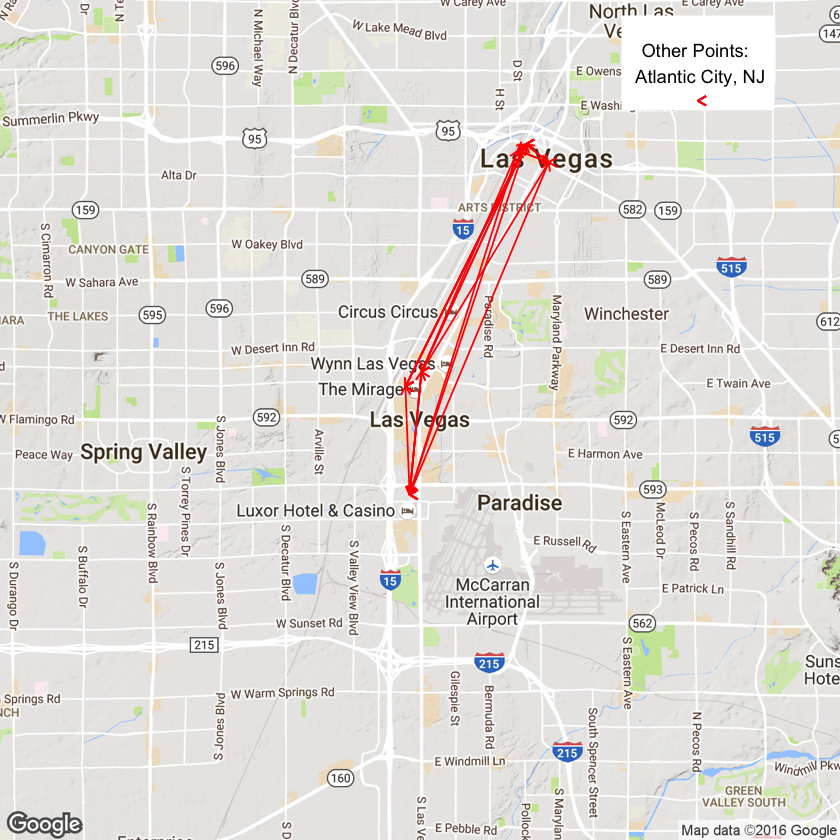

In [28]:
map <- qmap('Las Vegas', zoom = 12)
map <- map + annotate("rect", xmin = -115.08, xmax = -115.12, ymin = 36.18, ymax = 36.2, alpha = 1, fill="white")
map<-map + annotate("text", x =-115.1, y = 36.19 , label = "Other Points: \n Atlantic City, NJ",colour = "black")

tempexchange <- exchangeDF
tempexchange[tempexchange==39.3561]<- 36.182
tempexchange[tempexchange==-74.4358]<- -115.1
map<-map + geom_segment(data = tempexchange, aes(x = Hand.Loc.Lon, y = Hand.Loc.Lat,xend=New.Hand.Loc.Lon, yend=New.Hand.Loc.Lat), color="red", arrow = arrow(length = unit(0.2, "cm")))

map
pdf(file="hand_trades.pdf", width=7, height=6)
map
dev.off()